In [1]:
# _*_ coding:utf-8 _*_

import numpy as np
import matplotlib.pyplot as plt
import scipy.io #???????????????????????
import math
import sklearn
import sklearn.datasets

import opt_utils
import testCase

%matplotlib inline
plt.rcParams['figure.figsize'] = (70, 40) # 设置默认尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# 使用梯度下降更新参数
def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    """
    L = len(parameters) // 2
    
    # 更新每个参数
    for l in range(L):
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
        
    return parameters

In [3]:
# 测试update_parameters_with_gd
print("-------------------- 测试update_parameters_with_gd-------------------")

parameters, grads, learning_rate = testCase.update_parameters_with_gd_test_case()
parameters = update_parameters_with_gd(parameters,grads,learning_rate)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

-------------------- 测试update_parameters_with_gd-------------------
W1 = [[ 1.63535156 -0.62320365 -0.53718766]
 [-1.07799357  0.85639907 -2.29470142]]
b1 = [[ 1.74604067]
 [-0.75184921]]
W2 = [[ 0.32171798 -0.25467393  1.46902454]
 [-2.05617317 -0.31554548 -0.3756023 ]
 [ 1.1404819  -1.09976462 -0.1612551 ]]
b2 = [[-0.88020257]
 [ 0.02561572]
 [ 0.57539477]]


In [14]:
# 小批量
def random_mini_batches(X,Y,mini_batch_size=64,seed=0):
    """
    """
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    # 打乱顺序
    permutation = list(np.random.permutation(m))# 返回长m随机数组，范围0到m-1
    shuffled_X = X[:, permutation] # 将每一列的数据按permutation的顺序来重新排列
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    # 分割
    num_complete_minibatches = math.floor(m / mini_batch_size)# 向下取整，分割训练集
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    # 第一步分割完毕剩下的数据集
    if m % mini_batch_size != 0:
        # 获取最后部分
        mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_minibatches:]
        mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_minibatches:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
        
    return mini_batches

In [15]:
#测试random_mini_batches
print("-------------测试random_mini_batches-------------")
X_assess,Y_assess,mini_batch_size = testCase.random_mini_batches_test_case()
mini_batches = random_mini_batches(X_assess,Y_assess,mini_batch_size)

print("第1个mini_batch_X 的维度为：",mini_batches[0][0].shape)
print("第1个mini_batch_Y 的维度为：",mini_batches[0][1].shape)
print("第2个mini_batch_X 的维度为：",mini_batches[1][0].shape)
print("第2个mini_batch_Y 的维度为：",mini_batches[1][1].shape)
print("第3个mini_batch_X 的维度为：",mini_batches[2][0].shape)
print("第3个mini_batch_Y 的维度为：",mini_batches[2][1].shape)

-------------测试random_mini_batches-------------
第1个mini_batch_X 的维度为： (12288, 64)
第1个mini_batch_Y 的维度为： (1, 64)
第2个mini_batch_X 的维度为： (12288, 64)
第2个mini_batch_Y 的维度为： (1, 64)
第3个mini_batch_X 的维度为： (12288, 20)
第3个mini_batch_Y 的维度为： (1, 20)


In [18]:
# 包含动量的梯度下降
def initialize_velocity(parameters):
    """"""
    L = len(parameters) // 2 # 神经网络层数
    v = {}
    
    for l in range(L):
        # 构造一个维度一样的矩阵，并初始化
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        
    return v

In [19]:
# 测试initialize_velocity
print("------测试initialize_velocity------------")
parameters = testCase.initialize_velocity_test_case()
v = initialize_velocity(parameters)
print('v["dW1"] = ' + str(v["dW1"]))
print('v["db1"] = ' + str(v["db1"]))
print('v["dW2"] = ' + str(v["dW2"]))
print('v["db2"] = ' + str(v["db2"]))

------测试initialize_velocity------------
v["dW1"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db1"] = [[ 0.]
 [ 0.]]
v["dW2"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db2"] = [[ 0.]
 [ 0.]
 [ 0.]]


In [27]:
# 更新动量参数（形式就是指数加权平均）
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """"""
    L = len(parameters) // 2
    for l in range(L):
        # 计算速度
        # 对梯度进行指数加权
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] - (1 - beta) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] - (1 - beta) * grads["db" + str(l + 1)]
        
        # 更新参数
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * v["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v["db" + str(l + 1)]
    return parameters, v 

In [28]:
#测试update_parameters_with_momentum
print("-------------测试update_parameters_with_momentum-------------")
parameters,grads,v = testCase.update_parameters_with_momentum_test_case()
update_parameters_with_momentum(parameters,grads,v,beta=0.9,learning_rate=0.01)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print('v["dW1"] = ' + str(v["dW1"]))
print('v["db1"] = ' + str(v["db1"]))
print('v["dW2"] = ' + str(v["dW2"]))
print('v["db2"] = ' + str(v["db2"]))

-------------测试update_parameters_with_momentum-------------
W1 = [[ 1.62324474 -0.61061169 -0.52727016]
 [-1.07246613  0.86630849 -2.30222242]]
b1 = [[ 1.74468887]
 [-0.76214267]]
W2 = [[ 0.31877121 -0.24884002  1.46141628]
 [-2.06053746 -0.32310438 -0.38489956]
 [ 1.1330982  -1.09990393 -0.17354552]]
b2 = [[-0.877624  ]
 [ 0.04387355]
 [ 0.58355726]]
v["dW1"] = [[ 0.11006192 -0.11447237 -0.09015907]
 [-0.05024943 -0.09008559  0.06837279]]
v["db1"] = [[ 0.01228902]
 [ 0.09357694]]
v["dW2"] = [[ 0.02678881 -0.05303555  0.06916608]
 [ 0.03967535  0.06871727  0.08452056]
 [ 0.06712461  0.00126646  0.11173103]]
v["db2"] = [[-0.02344157]
 [-0.16598022]
 [-0.07420442]]


In [33]:
# 初始化Adam所需参数
def initialize_adam(parameters):
    """"""
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        v["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        
        s["dW" + str(l + 1)] = np.zeros_like(parameters["W" + str(l + 1)])
        s["db" + str(l + 1)] = np.zeros_like(parameters["b" + str(l + 1)])
        
    return (v, s)

In [34]:
#测试initialize_adam
print("-------------测试initialize_adam-------------")
parameters = testCase.initialize_adam_test_case()
v,s = initialize_adam(parameters)

print('v["dW1"] = ' + str(v["dW1"])) 
print('v["db1"] = ' + str(v["db1"])) 
print('v["dW2"] = ' + str(v["dW2"])) 
print('v["db2"] = ' + str(v["db2"])) 
print('s["dW1"] = ' + str(s["dW1"])) 
print('s["db1"] = ' + str(s["db1"])) 
print('s["dW2"] = ' + str(s["dW2"])) 
print('s["db2"] = ' + str(s["db2"]))

-------------测试initialize_adam-------------
v["dW1"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db1"] = [[ 0.]
 [ 0.]]
v["dW2"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
v["db2"] = [[ 0.]
 [ 0.]
 [ 0.]]
s["dW1"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]]
s["db1"] = [[ 0.]
 [ 0.]]
s["dW2"] = [[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
s["db2"] = [[ 0.]
 [ 0.]
 [ 0.]]


In [39]:
# 更新参数
def update_parameters_with_adam(parameters,grads,v,s,t,learning_rate=0.01,beta1=0.9,beta2=0.999,esiplon=1e-8):
    """"""
    L = len(parameters) // 2
    v_corrected = {} # 偏差修正后的值
    s_corrected = {} # 修正后
    
    for l in range(L):
        # 梯度的移动平均值输入：“v,grads,beta1”，输出：“v”
        v["dW" + str(l + 1)] = beta1 * v["dW" + str(l + 1)] + (1 - beta1) * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta1 * v["db" + str(l + 1)] + (1 - beta1) * grads["db" + str(l + 1)]
        
        # 计算第一阶的偏差修正后的估计值，输入：“v,beta1，t”，输出：“v_corrected”
        v_corrected["dW" + str(l + 1)] = v["dW" + str(l + 1)] / (1 - np.power(beta1, t))
        v_corrected["db" + str(l + 1)] = v["db" + str(l + 1)] / (1 - np.power(beta1, t))
        
        # 计算平方梯度的移动平均值，输入：“s,grads， beta2”，输出：“s”
        s["dW" + str(l + 1)] = beta2 * s["dW" + str(l + 1)] + (1 - beta2) * np.square(grads["dW" + str(l + 1)])
        s["db" + str(l + 1)] = beta2 * s["db" + str(l + 1)] + (1 - beta2) * np.square(grads["db" + str(l + 1)])
        
        # 计算二阶段的偏差修正后的估计值， 输入：“s，beta2，t”，输出：“s_corrected”
        s_corrected["dW" + str(l + 1)] = s["dW" + str(l + 1)] / (1 - np.power(beta2, t))
        s_corrected["db" + str(l + 1)] = s["db" + str(l + 1)] / (1 - np.power(beta2, t))
        
        # 更新参数，输入：parameters，learning_rate，v_corrected，s_corrected，esiplon，输出“parameters”
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - learning_rate * (v_corrected["dW" + str(l + 1)] / np.sqrt(s_corrected["dW" + str(l + 1)] + esiplon))
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * (v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + esiplon))
        
    return (parameters,v,s)

In [40]:
#测试update_with_parameters_with_adam
print("-------------测试update_with_parameters_with_adam-------------")
parameters , grads , v , s = testCase.update_parameters_with_adam_test_case()
update_parameters_with_adam(parameters,grads,v,s,t=2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
print('v["dW1"] = ' + str(v["dW1"])) 
print('v["db1"] = ' + str(v["db1"])) 
print('v["dW2"] = ' + str(v["dW2"])) 
print('v["db2"] = ' + str(v["db2"])) 
print('s["dW1"] = ' + str(s["dW1"])) 
print('s["db1"] = ' + str(s["db1"])) 
print('s["dW2"] = ' + str(s["dW2"])) 
print('s["db2"] = ' + str(s["db2"])) 

-------------测试update_with_parameters_with_adam-------------
W1 = [[ 1.63178673 -0.61919778 -0.53561312]
 [-1.08040999  0.85796626 -2.29409733]]
b1 = [[ 1.75225313]
 [-0.75376553]]
W2 = [[ 0.32648046 -0.25681174  1.46954931]
 [-2.05269934 -0.31497584 -0.37661299]
 [ 1.14121081 -1.09245036 -0.16498684]]
b2 = [[-0.88529978]
 [ 0.03477238]
 [ 0.57537385]]
v["dW1"] = [[-0.11006192  0.11447237  0.09015907]
 [ 0.05024943  0.09008559 -0.06837279]]
v["db1"] = [[-0.01228902]
 [-0.09357694]]
v["dW2"] = [[-0.02678881  0.05303555 -0.06916608]
 [-0.03967535 -0.06871727 -0.08452056]
 [-0.06712461 -0.00126646 -0.11173103]]
v["db2"] = [[ 0.02344157]
 [ 0.16598022]
 [ 0.07420442]]
s["dW1"] = [[ 0.00121136  0.00131039  0.00081287]
 [ 0.0002525   0.00081154  0.00046748]]
s["db1"] = [[  1.51020075e-05]
 [  8.75664434e-04]]
s["dW2"] = [[  7.17640232e-05   2.81276921e-04   4.78394595e-04]
 [  1.57413361e-04   4.72206320e-04   7.14372576e-04]
 [  4.50571368e-04   1.60392066e-07   1.24838242e-03]]
s["db2"] = 

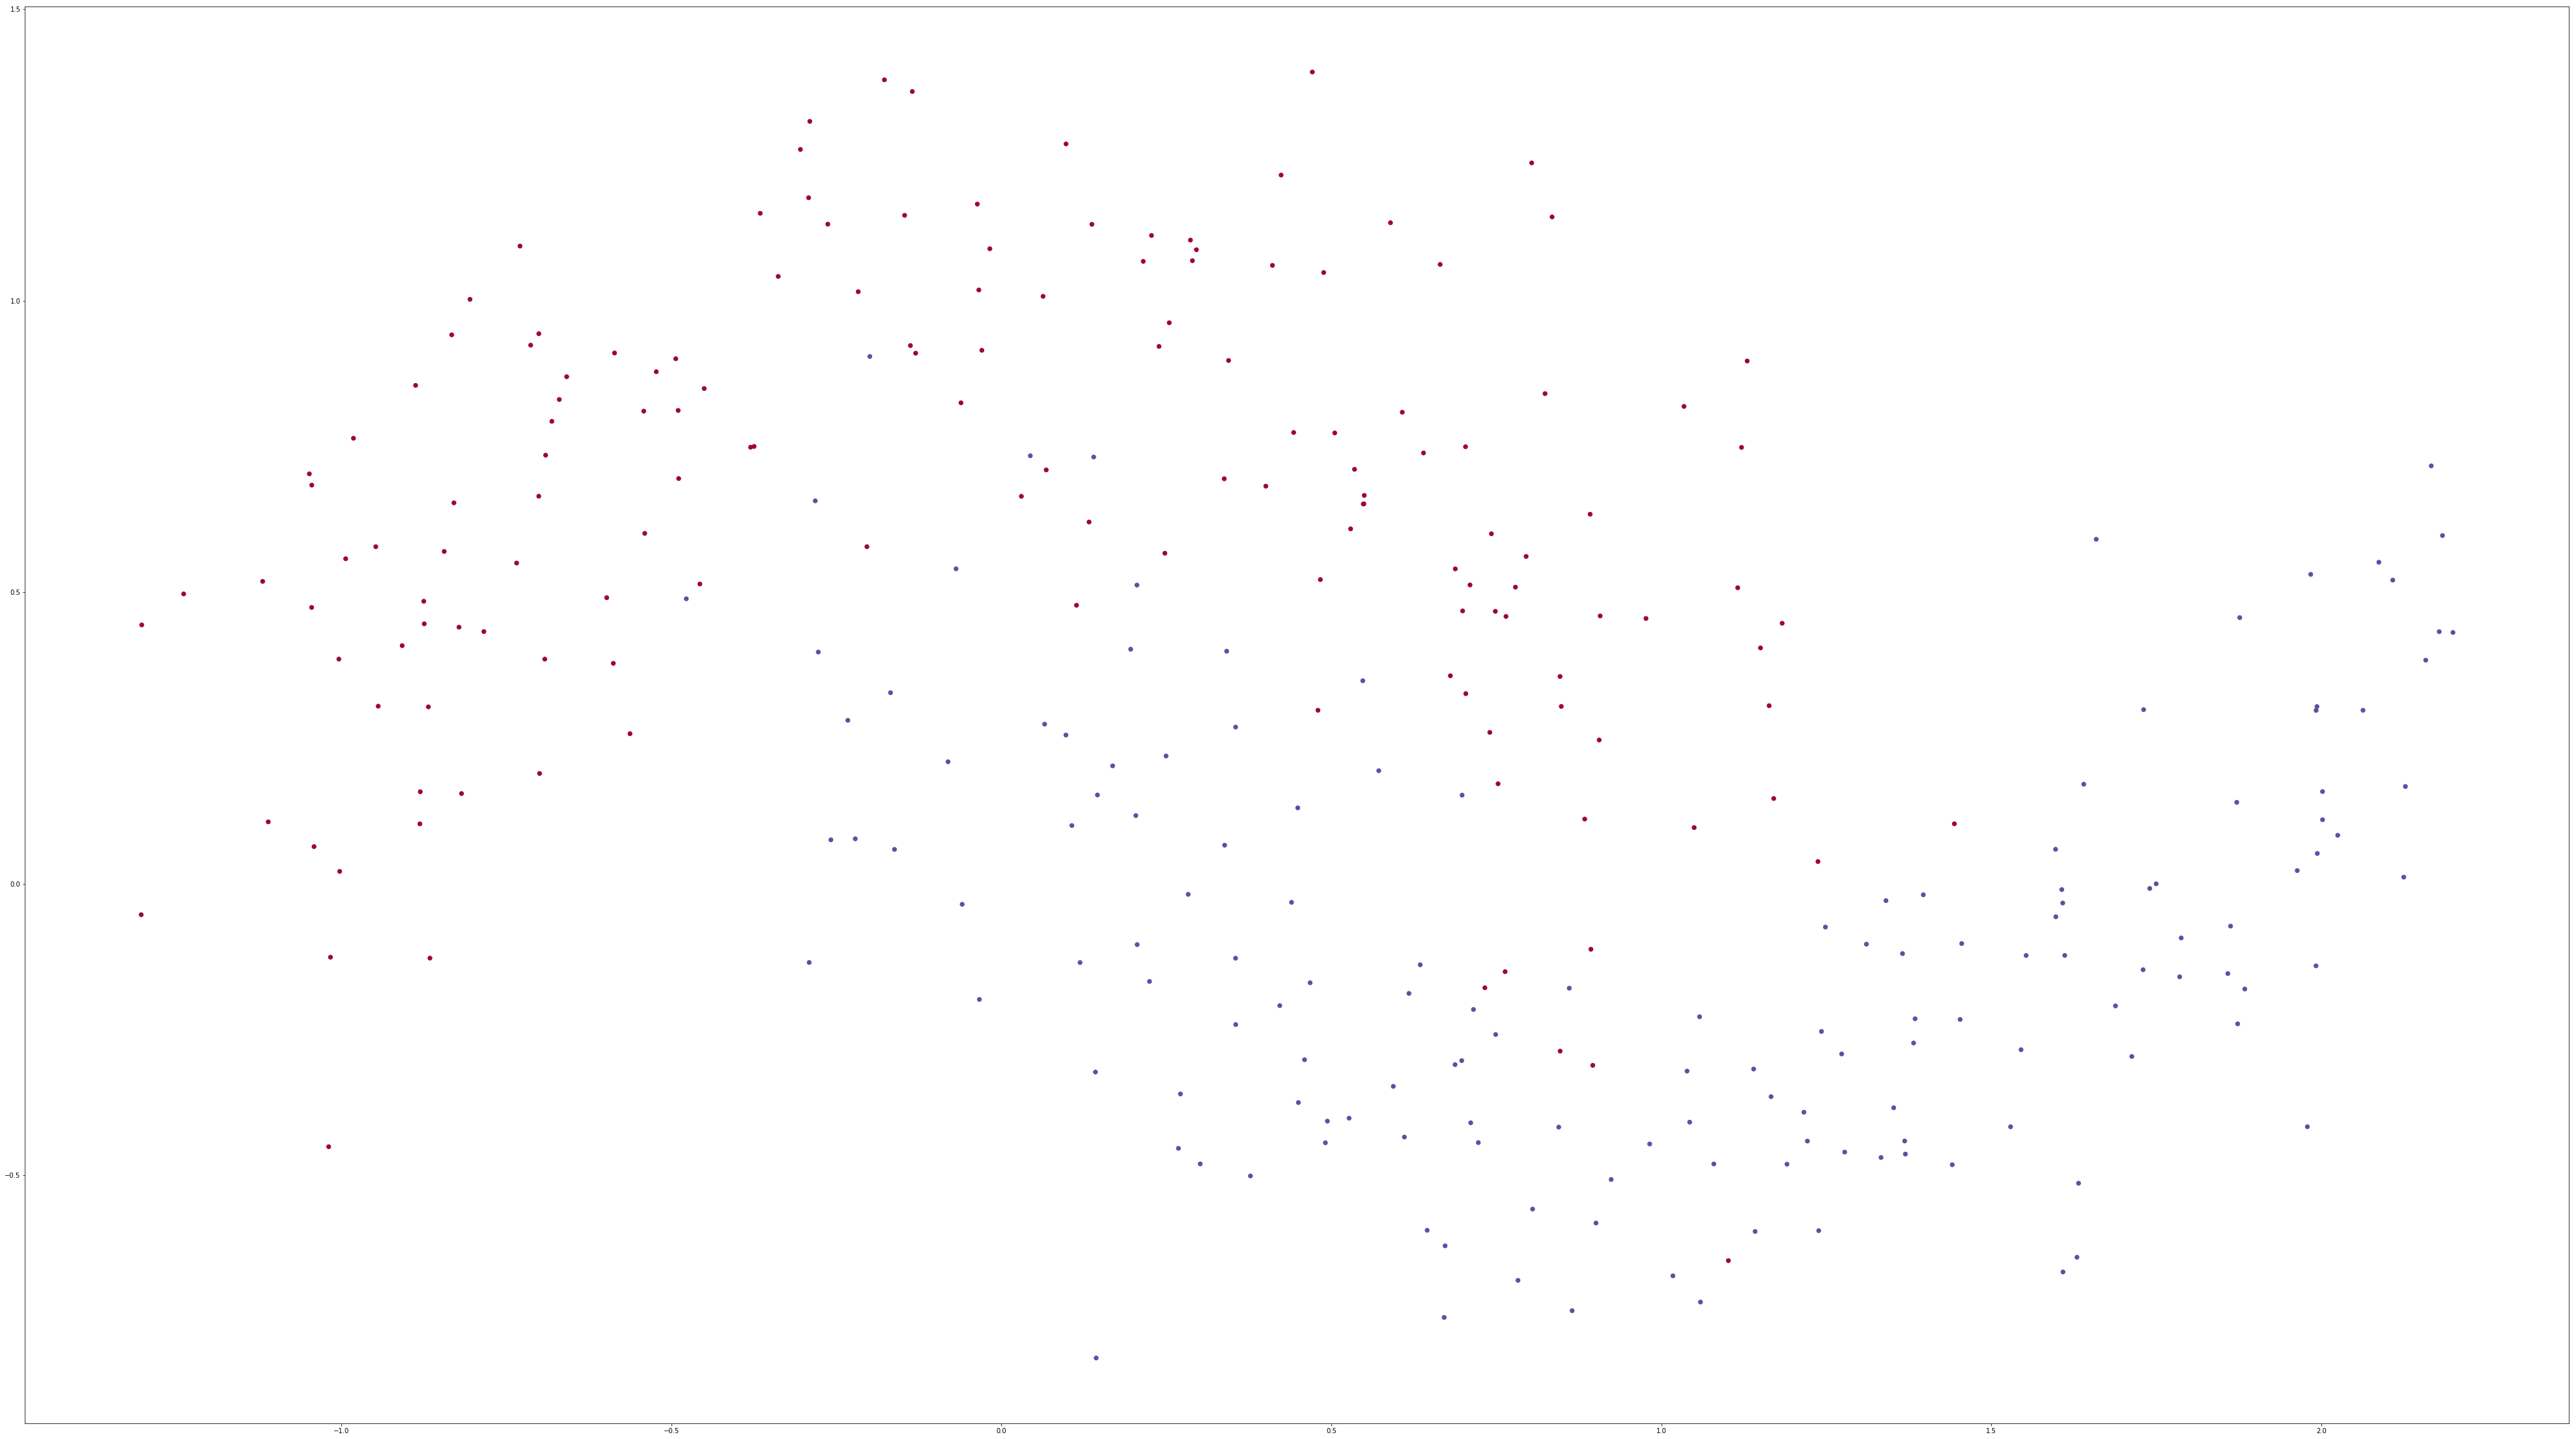

In [41]:
# 加载数据集
train_X, train_Y = opt_utils.load_dataset(is_plot=True)

In [60]:
# 定义模型
def model(X,Y,layers_dims,optimizer,learning_rate=0.0007,
         mini_batch_size=64,beta=0.9,beta1=0.9,beta2=0.999,
         esiplon=1e-8,num_epochs=10000,print_cost=True,is_plot=True):
    """"""
    L = len(layers_dims)
    costs = []
    t = 0 #学习完一个minibatch就加1
    seed = 10 # 随机种子
    
    # 初始优化参数
    parameters = opt_utils.initialize_parameters(layers_dims)
    
    # 选择优化器
    if optimizer == "gd":
        pass #不适用优化器
    elif optimizer == "momentum":
        v = initialize_velocity(parameters) #使用动量
    elif optimizer == "adam":
        v, s = initialize_adam(parameters) # 使用Adam
    else:
        print("optimizer参数报错，程序退出")
        exit(1)
        
    # 开始学习
    for i in range(num_epochs):
        # 随机定义，minibaches，每次遍历数据集之后增加种子重新排列数据集，使得每次数据的顺序不同
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
        
        for minibatch in minibatches:
            # 选择一个minibatch
            (minibatch_X, minibatch_Y) = minibatch
            
            #向前
            A3, cache = opt_utils.forward_propagation(minibatch_X, parameters)
            
            # 计算误差
            cost = opt_utils.compute_cost(A3, minibatch_Y)
            
            # 反向
            grads = opt_utils.backward_propagation(minibatch_X,minibatch_Y,cache)
            
            # 更新参数
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters,grads,learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1
                parameters, v, s = update_parameters_with_adam(parameters,grads,v,s,t,learning_rate,beta,beta1,beta2,esiplon)
        
    # 记录误差值
    if i % 100 == 0:
        costs.append(cost)
        # 是否打印
        if print_cost and i % 1000 == 0:
            print("第" + str(i) + "次遍历整个数据集，当前误差值：" + str(cost))
            
    #是否绘制曲线
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epochs(per 100)')
        plt.title("Learning rate = " + str(learning_rate))
        plt.show()
        
    return parameters

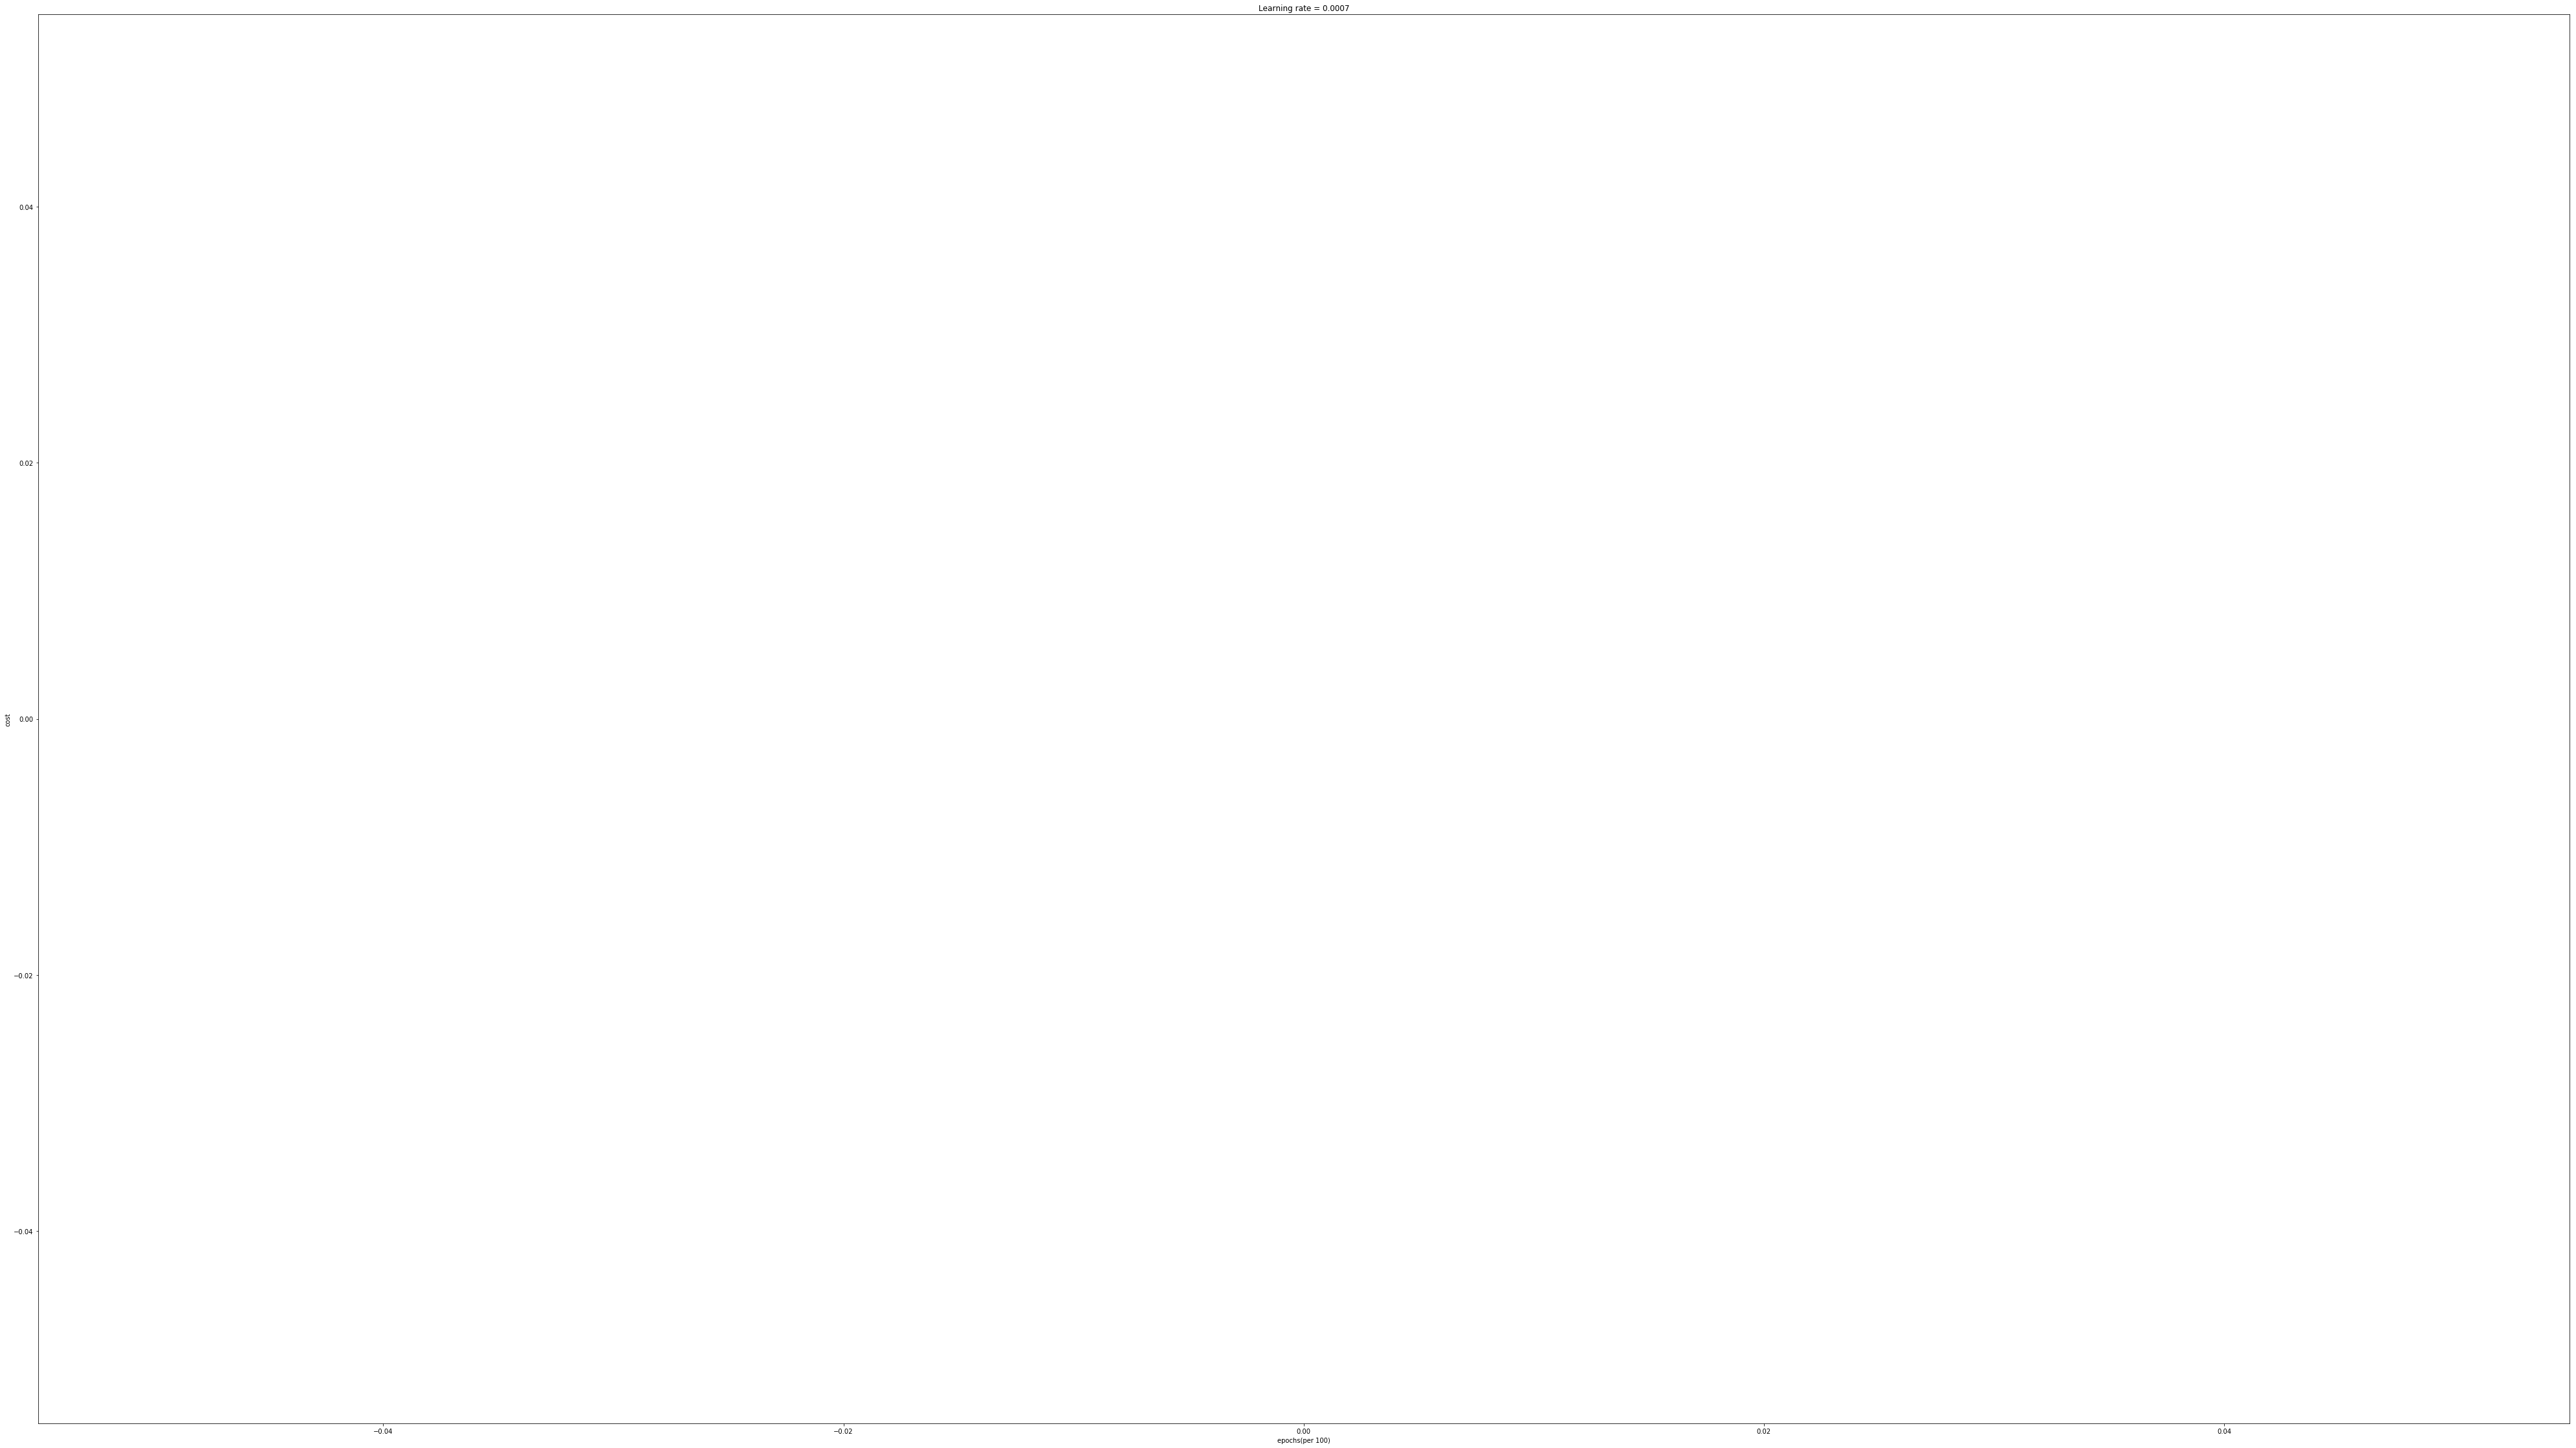

In [61]:
# 使用普通的梯度下降
layers_dims = [train_X.shape[0],5,2,1]
parameters = model(train_X, train_Y, layers_dims, optimizer = "gd", is_plot = True)

Accuracy: 0.796666666667


ValueError: c of shape (1, 300) not acceptable as a color sequence for x with size 300, y with size 300

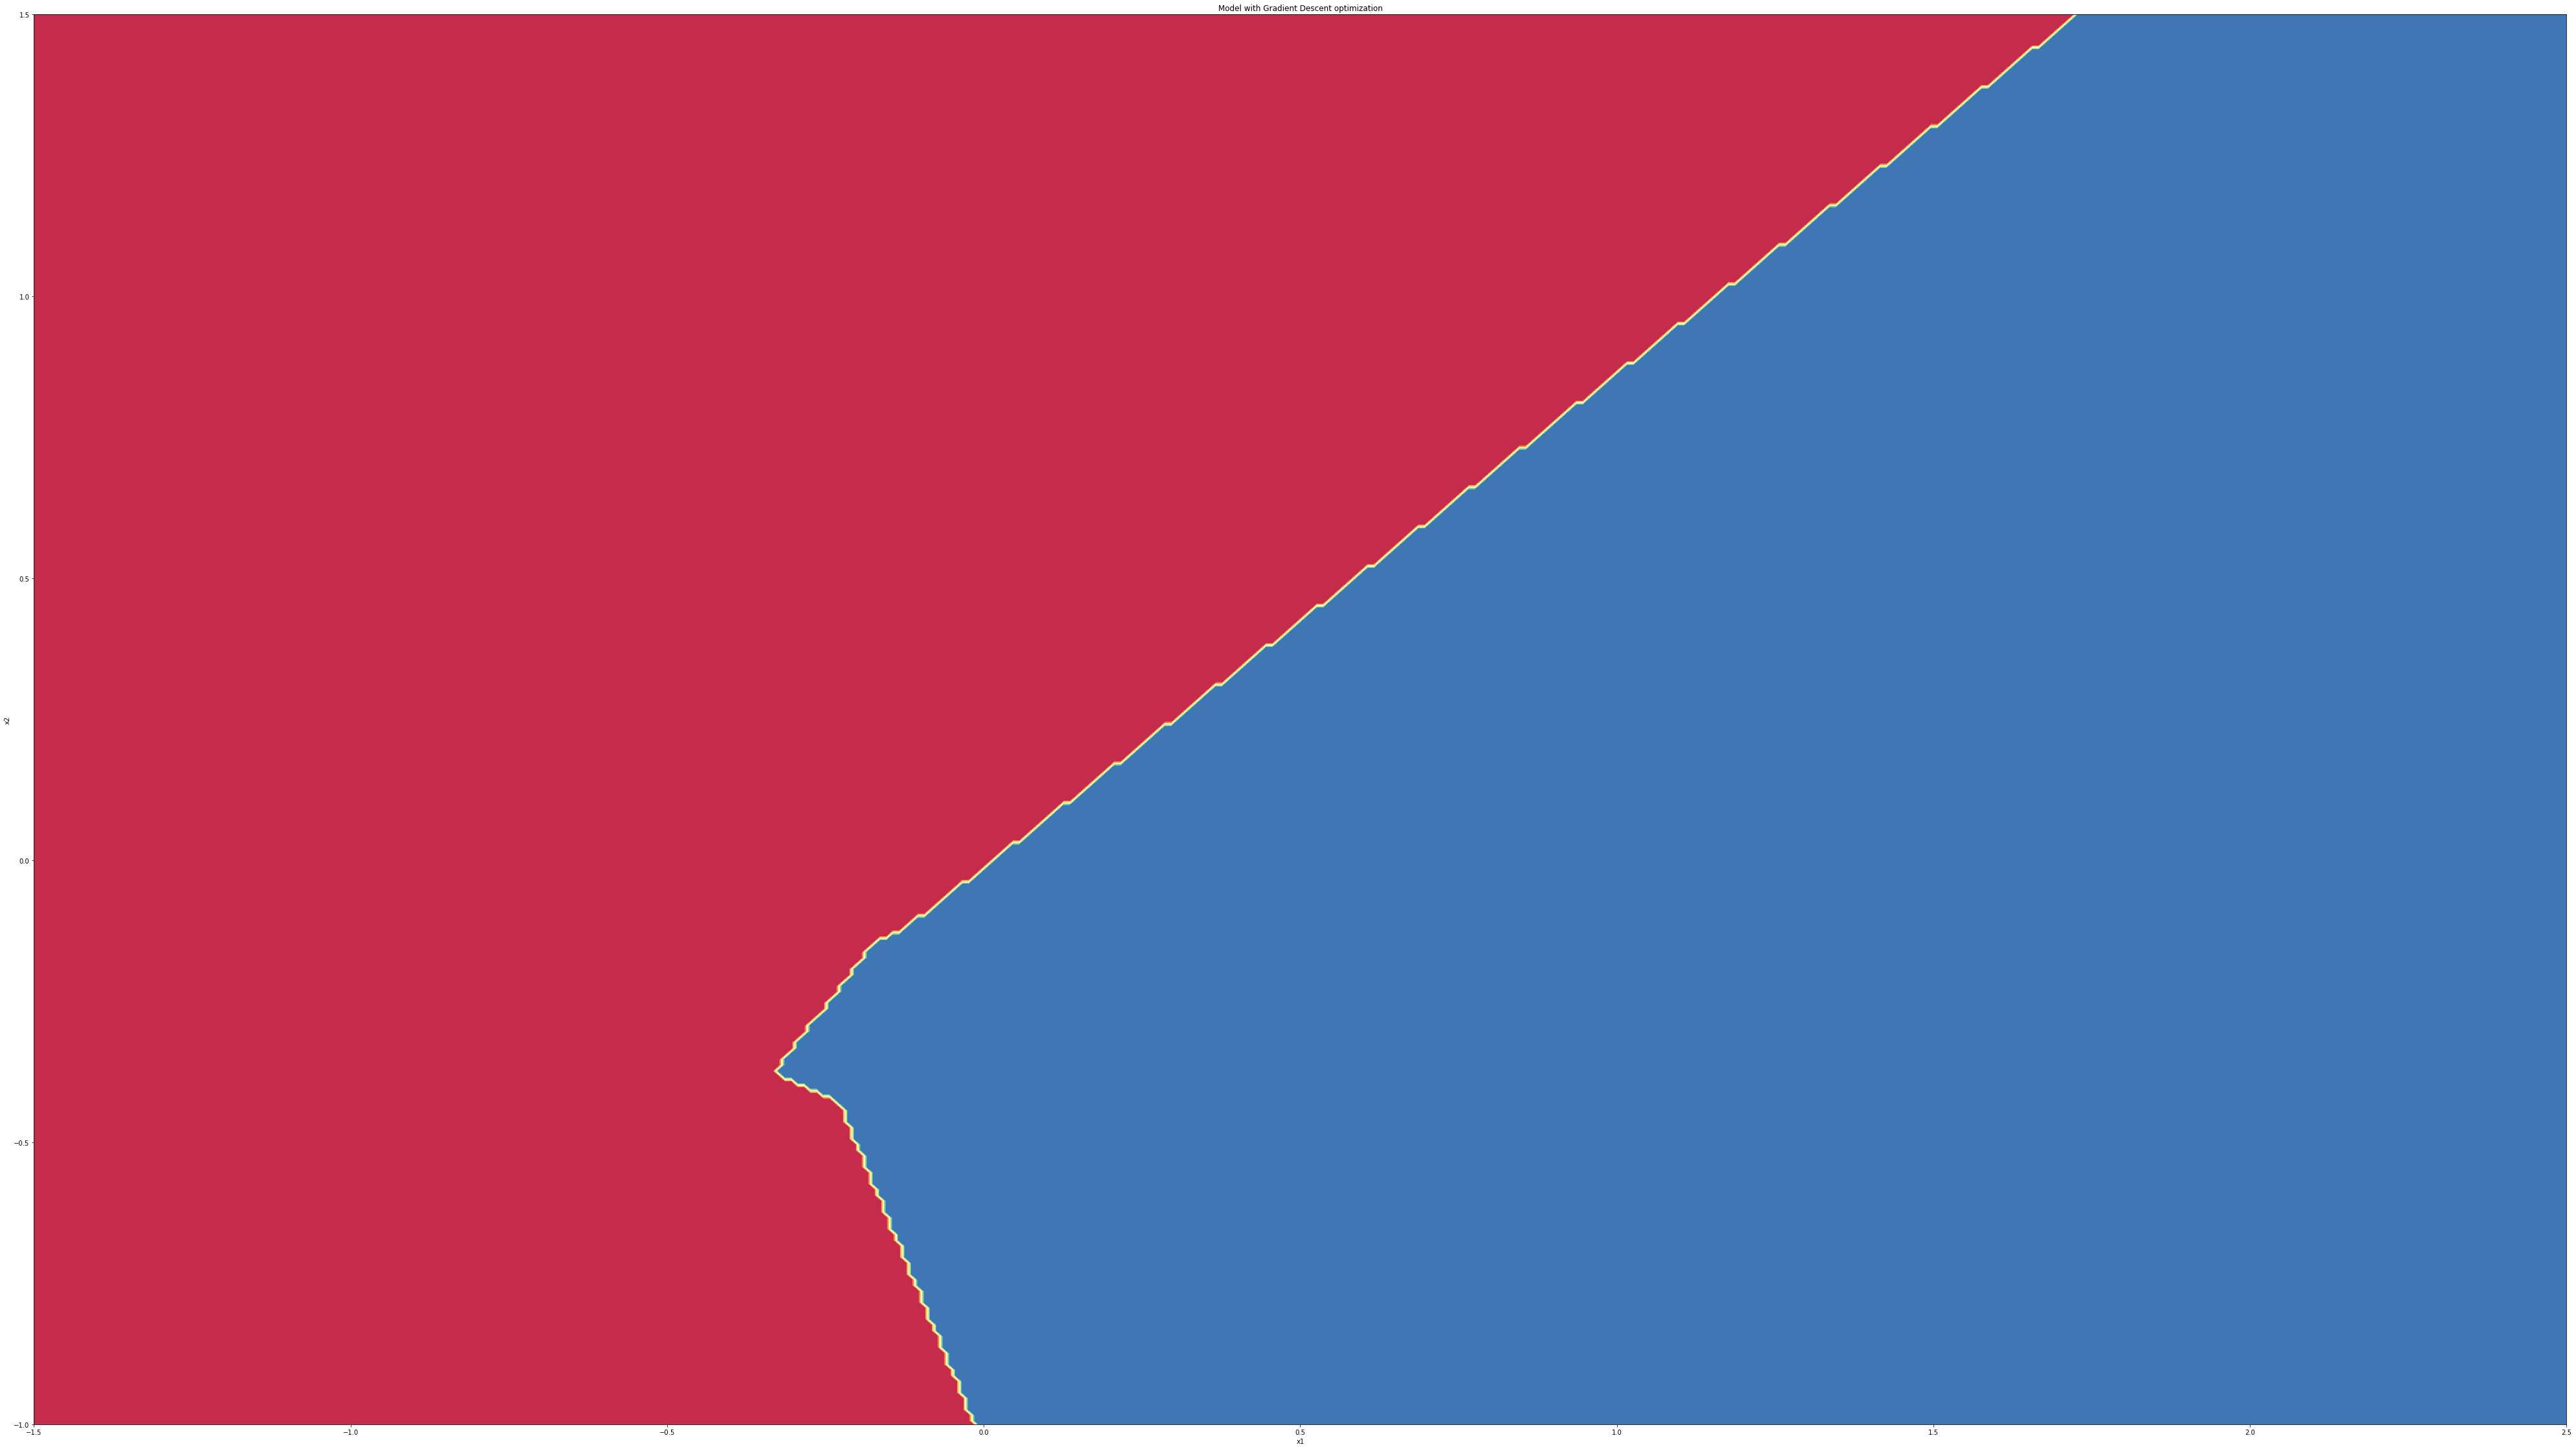

In [62]:
# 预测
predictions = opt_utils.predict(train_X, train_Y, parameters)

# 绘制分类图
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, train_Y)

In [ ]:
layers_dims = [train_X.shape[0],5,2,1]
#使用动量的梯度下降
parameters = model(train_X, train_Y, layers_dims, beta=0.9,optimizer="momentum",is_plot=True)

In [ ]:
#预测
preditions = opt_utils.predict(train_X,train_Y,parameters)

#绘制分类图
plt.title("Model with Momentum optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, train_Y)


In [ ]:
layers_dims = [train_X.shape[0], 5, 2, 1]
#使用Adam优化的梯度下降
parameters = model(train_X, train_Y, layers_dims, optimizer="adam",is_plot=True)

Accuracy: 0.796666666667


ValueError: c of shape (1, 300) not acceptable as a color sequence for x with size 300, y with size 300

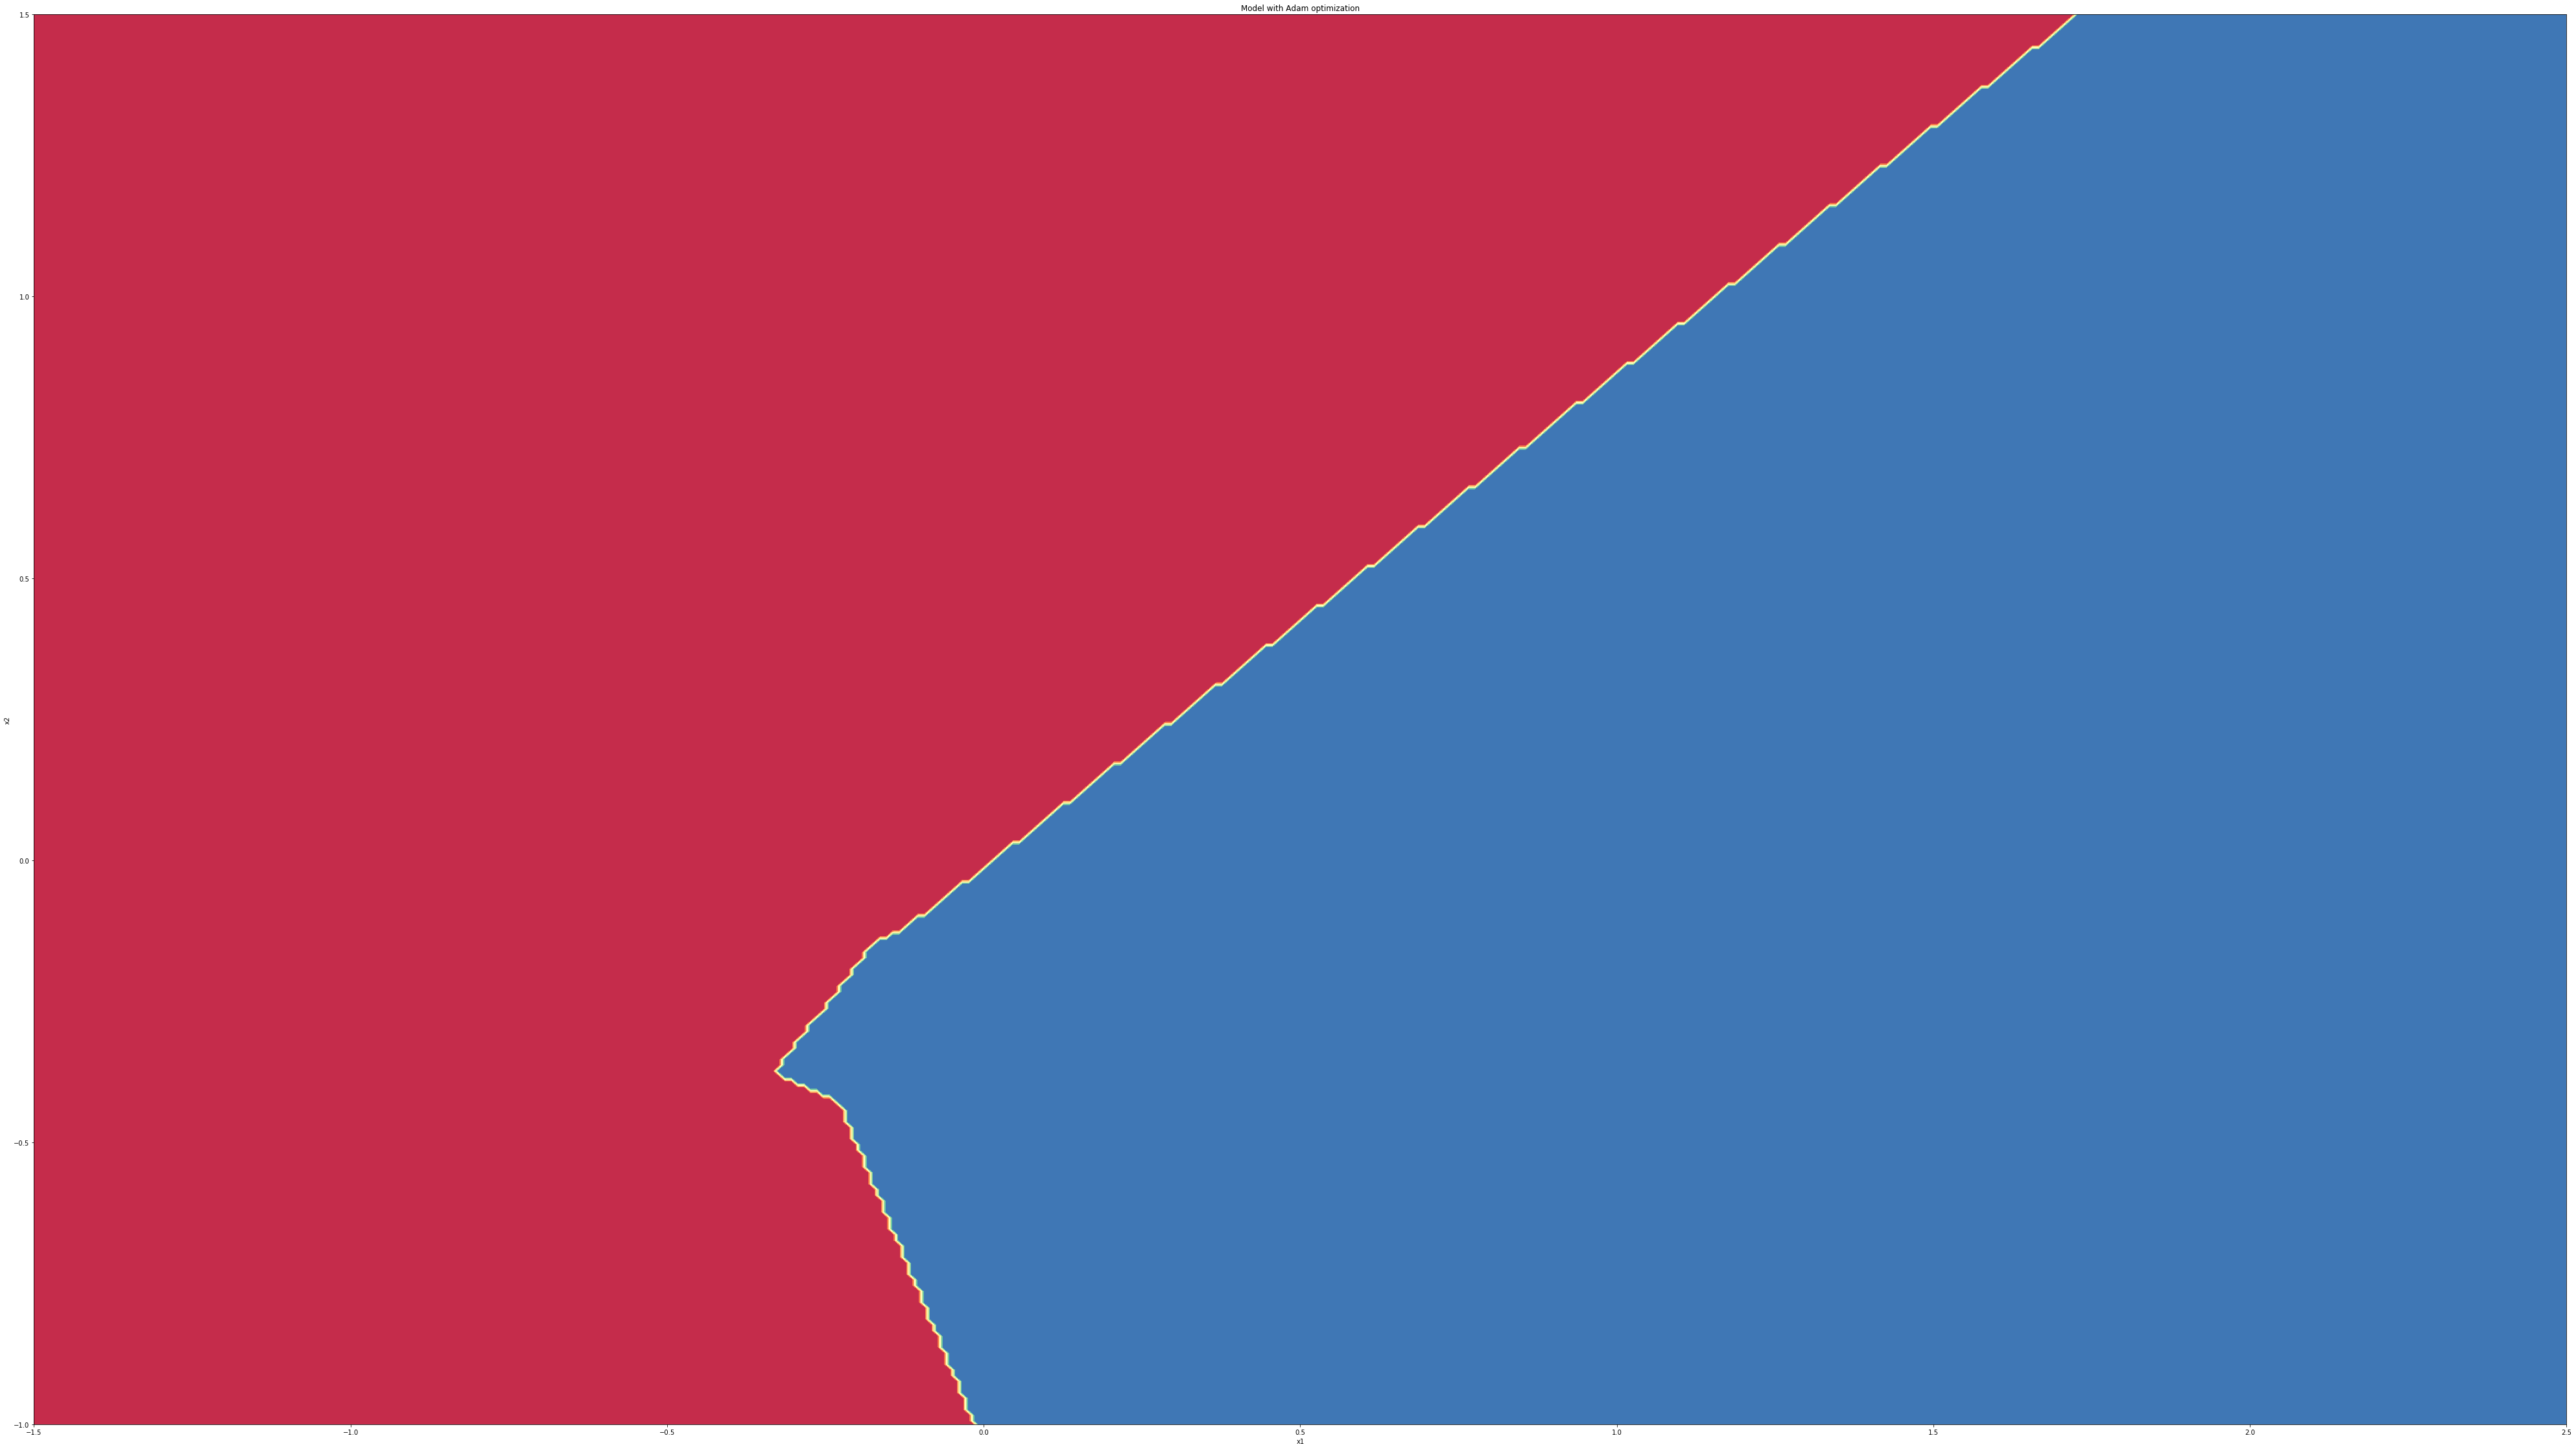

In [59]:
#预测
preditions = opt_utils.predict(train_X,train_Y,parameters)

#绘制分类图
plt.title("Model with Adam optimization")
axes = plt.gca()
axes.set_xlim([-1.5, 2.5])
axes.set_ylim([-1, 1.5])
opt_utils.plot_decision_boundary(lambda x: opt_utils.predict_dec(parameters, x.T), train_X, train_Y)